# Collecter les données

In [1]:
%%js
// pull down jquery into the JavaScript console
var script = document.createElement('script');
script.src = "https://ajax.googleapis.com/ajax/libs/jquery/2.2.0/jquery.min.js";
document.getElementsByTagName('head')[0].appendChild(script);

// grab the URLs
var urls = $('.rg_di .rg_meta').map(function() { return JSON.parse($(this).text()).ou; });

// write the URls to file (one per line)
var textToSave = urls.toArray().join('\n');
var hiddenElement = document.createElement('a');
hiddenElement.href = 'data:attachment/text,' + encodeURI(textToSave);
hiddenElement.target = '_blank';
hiddenElement.download = 'google_urls.txt';
hiddenElement.click();

<IPython.core.display.Javascript object>

In [2]:
from imutils import paths
import requests
import os

def download_img(urls_path, output_path, prefix="img"):
    # grab the list of URLs from the input file, then initialize the
    # total number of images downloaded thus far
    rows = open(urls_path).read().strip().split("\n")
    total = 0

    # loop the URLs
    for url in rows:
        try:
            # try to download the image
            r = requests.get(url, timeout=60)

            # save the image to disk
            p = os.path.sep.join([output_path, "{}.jpg".format(
                str(total).zfill(5))])
            f = open(p, "wb") # binary format
            f.write(r.content)
            f.close()

            # update the counter
            print("[INFO] downloaded: {}".format(p))
            total += 1

        # handle if any exceptions are thrown during the download process
        except:
            print("[INFO] error downloading {}...skipping".format(p))
            
# download("google_urls.txt", "tmp_img/cat", "google")

In [3]:
from imutils import paths
import cv2
import os

def clean_imgs(directory_path):
    # loop over the image paths we just downloaded
    for image_path in paths.list_images(directory_path):
        # initialize if the image should be deleted or not
        delete = False

        # try to load the image
        try:
            image = cv2.imread(image_path)

            # if the image is `None` then we could not properly load it
            # from disk, so delete it
            if image is None:
                delete = True

        # if OpenCV cannot load the image then the image is likely
        # corrupt so we should delete it
        except:
            print("Except")
            delete = True

        # check to see if the image should be deleted
        if delete:
            print("[INFO] deleting {}".format(image_path))
            os.remove(image_path)
            
# clean_imgs("tmp_img/cat")

#### Cat

| Source | Total |
| --------------| -----------|
| [google image](https://www.google.com/search?q=cat&source=lnms&tbm=isch&sa=X&ved=0ahUKEwi8oKaNw5jYAhWG8RQKHVfoD7kQ_AUICigB&biw=1920&bih=968) | 610 |
| [imagenet](https://www.image-net.org/synset?wnid=n02121620) | 861 |
| [kaggle](https://www.kaggle.com/c/dogs-vs-cats/data) | 12500 |
| **total** | 13471 |

#### !Cat

| Source | Total |
| --------------| -----------|
| [ukbench](https://archive.org/details/ukbench) | 2550 |

#### Nettoyage

A la main

#### Annotation

Le nom du répertoire où on stocke les images fait office d'annotation.
Les images de chat sont placées dans un répertoire **cat**.
Les images qui ne contiennent pas de chats sont placées dans un répertoire **not_cat**.

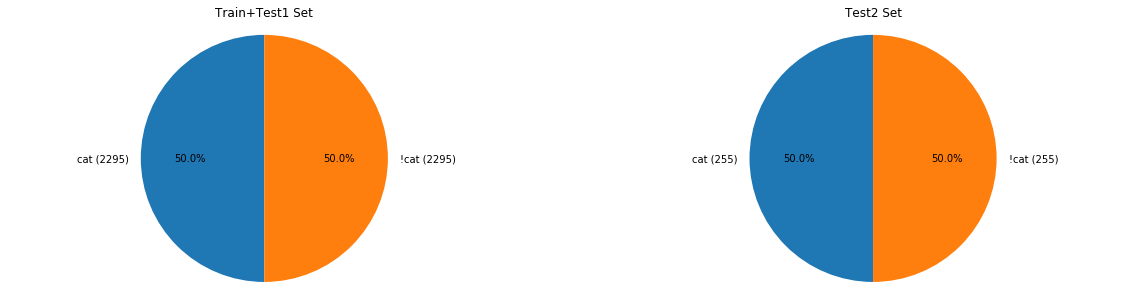

In [4]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
# @see https://matplotlib.org/glossary/index.html#term-agg
matplotlib.use("Agg")
%matplotlib inline

from importlib import reload
from imgpred import gvutils
reload(gvutils)
# Division en 2 sous-ensembles "train" (9/10eme) et "test2" (1/10eme) contenant chacun 50% de cat/not_cat
gvutils.create_sets("tmp_img", "images")
gvutils.imgs_stats("images")

# Neural Network

## [LeNet](https://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/)

In [5]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K

class LeNet:
    @staticmethod
    def build(width=28, height=28, depth=3, classes=2):
        #initialize the model
        model = Sequential()
        inputShape = (height, width, depth)

        # if we are using 'channels first', update the input shape
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)

        # first set of CONV => RELU => POOL layers
        model.add(Conv2D(20, (5, 5), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

        # second set of CONV => RELU => POOL layers
        model.add(Conv2D(50, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

Using TensorFlow backend.


# Classification

In [6]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
# @see https://matplotlib.org/glossary/index.html#term-agg
matplotlib.use("Agg")
%matplotlib inline

# import the necessary packages
from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os

from keras.models import load_model
import sys

F:\Users\Gabriel\Anaconda3\envs\opencv\lib\site-packages\ipykernel_launcher.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "F:\Users\Gabriel\Anaconda3\envs\opencv\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "F:\Users\Gabriel\Anaconda3\envs\opencv\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "F:\Users\Gabriel\Anaconda3\envs\opencv\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "F:\Users\Gabriel\Anaconda3\envs\opencv\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "F:\Users\Gabriel\Anaconda3\envs\opencv\lib\site-packages\ipykernel

In [7]:
def my_train_test_split(dataset_path, img_width):
    # init the data and labels
    print("[INFO] loading images...")
    data=[]
    labels=[]

    image_paths = sorted(list(paths.list_images(dataset_path)))
    random.seed(42)
    random.shuffle(image_paths)

    for image_path in image_paths:
        img = cv2.imread(image_path)
        img = cv2.resize(img, (img_width, img_width))
        img = img_to_array(img)
        data.append(img)

        # os.path.sep => '\\' on Windows
        label = image_path.split(os.path.sep)[-2]
        label = 1 if label == "cat" else 0
        labels.append(label)

    # scale the raw pixel intensities to the range [0,1]
    data = np.array(data, dtype="float") / 255.0
    labels = np.array(labels)

    # partition the data into training and testing splits using 75% of
    # the data for training and the remaining 25% for testing
    (trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

    # convert the labels from integers to vectors
    # [0,1,0] => [[1,0], [0,1], [1,0]]
    trainY = to_categorical(trainY, num_classes=2)
    testY = to_categorical(testY, num_classes=2)
    return (trainX, testX, trainY, testY)

def train_network(dataset_path, width, model_path, network_class=LeNet, verbose=1):
    # @see https://keras.io/getting-started/faq/#what-does-sample-batch-epoch-mean
    # initialize the number of epochs to train for, initial learning rate,
    # and batch size
    EPOCHS = 25 # training epochs
    INIT_LR = 1e-3 # initial learning rate
    BS = 32 # batch size
    IMG_WIDTH = width

    (trainX, testX, trainY, testY) = my_train_test_split(dataset_path, IMG_WIDTH)
    
    """
    construct the image generator for data augmentation
    @see https://keras.io/preprocessing/image/
    """
    aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

    # init the model
    print("[INFO] compiling model...")
    model = network_class.build(width=IMG_WIDTH, height=IMG_WIDTH, depth=3, classes=2)

    """
    https://keras.io/optimizers/#adam
    https://arxiv.org/abs/1412.6980v8
    """
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

    """
    https://keras.io/losses/
    https://keras.io/metrics/
    https://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/
    https://en.wikipedia.org/wiki/Loss_function
    """
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

    # train the network
    print("[INFO] training network...")
    # https://keras.io/models/model/#fit_generator
    callbacks=[]
    callbacks.append(TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=BS, 
                                               write_graph=True, write_grads=False, write_images=False, 
                                               embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None))
    H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS), validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS, epochs=EPOCHS, verbose=verbose, callbacks=callbacks)

    # save the model to disk
    print("[INFO] serializing network...")
    model.save(model_path)

    return (EPOCHS, H)

In [8]:
from string import Template
import os
from imgpred import gvutils

def preprocess(img_path, width):
    # pre-process the image for classification
    image = cv2.imread(img_path)
    image = cv2.resize(image, (width, width))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    # https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.expand_dims.html
    image = np.expand_dims(image, axis=0)
    return image

def test_network(dataset_path, width, model_path, verbose=1):
    # load the trained convolutional neural network
    verbose and print("[INFO] loading network...")
    model = load_model(model_path)

    verbose and print("[INFO] testing images...")
    counter = 0
    # tableaux de tuples (img_path, pred_label)
    imgs = {"tp": [],"tn": [], "fp": [], "fn": []}
    y_true, y_pred = [], []
    for img_path in paths.list_images(dataset_path):
        # classify the input image
        (not_cat, cat) = model.predict(preprocess(img_path, width))[0]
        verbose and print("[INFO] {0:.2f} {1:.2f}".format(not_cat, cat))
        img_label = 1 if img_path.split(os.path.sep)[-2] == "cat" else 0
        y_true.append( img_label )
        y_pred.append(1 if cat > not_cat else 0)

        # Confusion Matrix for img reporting
        conf = "foo"
        if (cat > not_cat and img_label == 1):
            conf = "tp"
        elif (cat < not_cat and img_label == 0):
            conf = "tn"
        elif (cat > not_cat and img_label == 0):
            conf = "fp"
        elif (cat < not_cat and img_label == 1):
            conf = "fn"
        imgs[conf].append((img_path, gvutils.pred_label(cat, not_cat)))

        # Progress bar
        counter += 1
        verbose and gvutils.print_progress(counter, 0.02)

    return (y_true, y_pred, imgs)

## Mise en pratique

In [ ]:
from imgpred import gvutils
from importlib import reload
reload(gvutils)

# %matplotlib inline
(N, H) = train_network("images/train", 28, "models/cat_not_cat_XX.model", LeNet, 0)
gvutils.print_save_plot(N, H, "reporting/plot_XX.png")
gvutils.imgs_stats("images")

In [ ]:
from imgpred import gvutils
reload(gvutils)
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

(y_true, y_pred, imgs) = test_network("images/test2", 128, "models/cat_not_cat_128px.model", False)
cm = confusion_matrix(y_true, y_pred)
# https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ravel.html
tn, fp, fn, tp = cm.ravel()
gvutils.plot_confusion_matrix(cm, classes=["Not Cat", "Cat"])
plt.show()
print("[INFO] accuracy={:.2f}".format(accuracy_score(y_true, y_pred)))

#print(str(imgs))
gvutils.save_confusion_matrix_samples(imgs, "reporting/conf_matrix_XX.png")

In [ ]:
for size in [28, 64, 128]:
    (N, H) = train_network("images/train", size, "models/cat_not_cat_{}px.model".format(size), LeNet, 0)
    gvutils.print_save_plot(N, H, "reporting/plot_{}px.png".format(size))

## TODO

* Train avec et sans **ImageGenerator**
* Supprimer les images qui génèrent le message "iCCP: known incorrect RGB profile"
* Tester test_network par batch de X images (au lieu de 1 à la fois) et évaluer rapidité d'exécution
* OK → Comprendre l'architecture LeNet et les étapes de train_network -> faire des schémas
* Pour comparer des classifieurs on utilise l'ensemble test1
 - par exemple pour comparer des classifieurs en faisant varier un paramètre du classifieur pour connaitre la meilleure valeur
* Pour évaluer le classifieur séléctionné on utilise l'ensembe test2
* Utiliser d'avantage numpy, sklearn, pandas... (dans test_network par exemple)
* Packager l'ensemble pour obtenir un projet clés en main
* Afficher les valeurs finales obtenues sur les graphes + max/min
* Créer un fichier rapport exhaustif de chaque essai (train+test) + images de résultats
* A quoi sert le **ImageDataGenerator** → image data preparation and augmentation?
* Que représente **loss** -> fonction d'évaluation du réseau lors de la phase d'entrainement -> binary cross entropy ?
* Que représente **epoch** et **batch** ?
    * **Batch**: a set of N samples. The samples in a batch are processed independently, in parallel. If training, a batch results in only one update to the model.
    * **Epoch**: an arbitrary cutoff, generally defined as "one pass over the entire dataset", used to separate training into distinct phases, which is useful for logging and periodic evaluation.
* Pourquoi LeNet ne se stabilise pas autour de la meilleure performance observée lors des itérations?
* Expliquer pourquoi la perf annoncée du classifieur après la phase d'entraînement peut différer de celle obtenue lors de la phase d'évaluation
* Comparer les résultats avec différentes tailles / réseaux

# [GridSearch](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/)

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# @see https://keras.io/getting-started/faq/#what-does-sample-batch-epoch-mean
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 25 # training epochs
INIT_LR = 1e-3 # initial learning rate
BS = 32 # batch size

# https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
def create_model():
    model = LeNet.build()
    model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    return model

model = KerasClassifier(build_fn=create_model, epochs=EPOCHS, batch_size=BS)

(trainX, testX, trainY, testY) = my_train_test_split("images/train", 28)
print("[INFO] data split done")

# cf. http://cs231n.github.io/neural-networks-3/
param_grid = dict(epochs=[10,20,30])
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=2, verbose=0)

In [ ]:
grid_result = grid.fit(trainX, trainY)
print(grid_result.best_score_, grid_result.best_params_)